# MLP Data Analysis

In [1]:
import pandas as pd
df = pd.read_csv('data/kinase_JAK.csv')

# See all values of measurement types and kinase names 
print("Unique Measurement Types: " + str(df['measurement_type'].unique()))
print("Unique Kinase Names: " + str(df['Kinase_name'].unique()))

# Look at overall data and view full representation of a SMILES string
print(df.head())

Unique Measurement Types: ['pIC50' 'pKi']
Unique Kinase Names: ['JAK2' 'JAK1' 'TYK2' 'JAK3']
                                              SMILES measurement_type  \
0  C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...            pIC50   
1  C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...            pIC50   
2      C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1            pIC50   
3      C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1            pIC50   
4              C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1            pIC50   

   measurement_value Kinase_name  
0               6.81        JAK2  
1               8.05        JAK1  
2              10.26        JAK2  
3              10.26        JAK1  
4               7.36        JAK2  


### Pulling features from SMILES representations
RDKit actually has built-in ways of pulling molecule descriptors out of SMILES strings. A list of them can be found [here](https://www.rdkit.org/docs/source/rdkit.Chem.rdMolDescriptors.html) and as I don't trust my knowledge of chemistry enough to invalidate any of them, I will examine the entire set to determine if they will be useful in predicting pKi for any of the target kinases. 

## Data Exploration

In [2]:
# Separate out kinase measurements, see how many there are and verify no duplicate [smile, kinase] pairs
kinases = ['JAK1', 'JAK2', 'JAK3', 'TYK2']
df_kinase = df.loc[df['measurement_type'] == 'pKi']
print("# of Kinase Measurements: " + str(df_kinase.shape[0]))

unique_pairs = df_kinase[['Kinase_name', 'SMILES']].value_counts().reset_index(name='count').shape[0]
print("# Unique Kinase Measurements: " + str(unique_pairs))

# Count number of data points for each kinase
for kin in kinases:
    num_kin_measurements = df_kinase.loc[df_kinase['Kinase_name'] == kin].shape[0]
    print("# of " + kin + " measurements: " + str(num_kin_measurements))


# of Kinase Measurements: 1989
# Unique Kinase Measurements: 1989
# of JAK1 measurements: 685
# of JAK2 measurements: 804
# of JAK3 measurements: 337
# of TYK2 measurements: 163


Here we see that there is a particularly low sample count for TYK2. This means that there is a lack of information here that could be difficult to make up. As an extension, it may be worth attempting to use transfer learning to establish a neural network trained on the Kinase most similar to TYK2 and adapting it with the small TYK2 data.

In [3]:
# Mutate data such that each SMILES has one unique row, creating columns for each kinase pKi
df_smiles = df_kinase.pivot(index="SMILES", columns="Kinase_name", values='measurement_value')
df_smiles = df_smiles.reset_index()
pd.options.display.max_colwidth=10
print(df_smiles)
print("# Molecules: " + str(df_smiles.shape[0]))

Kinase_name     SMILES  JAK1  JAK2  JAK3  TYK2
0            Brc1cn...   NaN  6.20   6.3   NaN
1            C#Cc1c...   NaN  6.20   NaN   NaN
2            C=CC(=...  8.20   NaN   8.2   NaN
3            C=CCN(...  8.49  8.14   NaN   NaN
4            CC(=NN...   NaN  6.00   6.0   NaN
..                 ...   ...   ...   ...   ...
979          c1ccc(...   NaN  6.55   6.0   NaN
980          c1ccc(...   NaN  6.20   NaN   NaN
981          c1cnc2...   NaN  6.90   6.8   6.5
982          c1cncc...  7.80  7.55   NaN   NaN
983          c1nc(-...   NaN  6.00   NaN   NaN

[984 rows x 5 columns]
# Molecules: 984


In [5]:
# Now that each line in df_smiles is unique, let's expand some features
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Descriptors3D
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (400, 300)
IPythonConsole.ipython_useSVG=True

def getMolDescriptors(mol):
    all_descriptors = {}
    for name, equation in Descriptors._descList:
        try:
            val = equation(mol)
        except:
            val = None
        all_descriptors[name] = val
    return all_descriptors

for index, row in df_smiles.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptors = getMolDescriptors(mol)
    for name in descriptors: 
        df_smiles.loc[index, name] = descriptors[name]

display(df_smiles)

Kinase_name,SMILES,JAK1,JAK2,JAK3,TYK2,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Brc1cn...,NaN,6.20,6.3,NaN,4.324474,0.918568,4.324474,0.918568,0.713045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C#Cc1c...,NaN,6.20,NaN,NaN,8.868717,0.386681,8.868717,0.386681,0.577516,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C=CC(=...,8.20,NaN,8.2,NaN,11.895783,-0.010668,11.895783,0.010668,0.845167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C=CCN(...,8.49,8.14,NaN,NaN,13.565301,-3.122653,13.565301,0.088300,0.139748,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CC(=NN...,NaN,6.00,6.0,NaN,12.703095,-0.412285,12.703095,0.326835,0.047129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,c1ccc(...,NaN,6.55,6.0,NaN,4.256136,0.724003,4.256136,0.724003,0.625137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
980,c1ccc(...,NaN,6.20,NaN,NaN,4.517340,0.582184,4.517340,0.582184,0.623770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
981,c1cnc2...,NaN,6.90,6.8,6.5,4.689446,0.507996,4.689446,0.507996,0.771229,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
982,c1cncc...,7.80,7.55,NaN,NaN,4.441994,0.384860,4.441994,0.384860,0.623421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Normalize all features to z-scores and print feature list
non_feature_cols = ['SMILES', 'JAK1', 'JAK2', 'JAK3', 'TYK2']
feature_cols = []
for column in df_smiles.columns:
    if column not in non_feature_cols:
        df_smiles[column] = (df_smiles[column] -df_smiles[column].mean()) / df_smiles[column].std()
        feature_cols.append(column)

print(feature_cols)

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'Slo

## Feature Engineering
### Low variance featues
As all features have been normalized, we will remove all features with a variance of < 0.05. This is just a standard removal of constant features. It looks as if no features were actually removed by this threshold.

In [7]:
# Remove all features with low variance
feature_candidates = feature_cols
for feature in feature_candidates:
    if df_smiles[feature].var() < 0.05:
        feature_candidates.remove(feature)
print("# of low variance features removed: " + str(len(feature_cols) - len(feature_candidates))) 

# of low variance features removed: 0


## Feature Correlation
We will be removing features that are not correlated with the pKi of any of the kinases, as these will likely have little use in our network and would only work as confounding variables. Let's also examine the distribution of each of these features to make sure that we can safely use the Pearson correlation coefficient to make these judgement calls.

<Figure size 640x480 with 0 Axes>

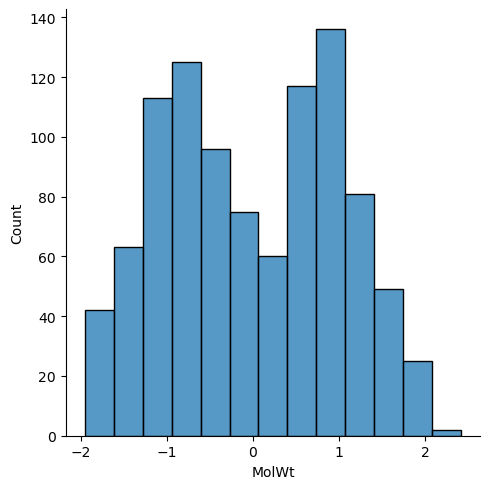

# Normal features: 187
# Non-normal features: 21


In [8]:
# Check distribution of each of the features
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def plot_distribution(df, feature):
    plt.figure()
    sns.displot(df, x=feature)
    plt.show()

normal_features = []
non_normal_features = []
for feature in feature_cols:
#     plot_distribution(df_smiles, feature)
    stats, p = shapiro(df_smiles[feature])
    if p < 0.05:
        normal_features.append(feature)
    else:
        non_normal_features.append(feature)
        
plot_distribution(df_smiles, 'MolWt')
print("# Normal features: " + str(len(normal_features)))
print("# Non-normal features: " + str(len(non_normal_features)))

In [9]:
# Check most correlated with each of the different kinases
df_jak1 = df_smiles.dropna(subset=['JAK1'])
df_jak2 = df_smiles.dropna(subset=['JAK2'])
df_jak3 = df_smiles.dropna(subset=['JAK3'])
df_tyk2 = df_smiles.dropna(subset=['TYK2'])
print(df_jak3['JAK3'].mean())
print(df_jak3['JAK3'].var())
kinase_indices = {
    'JAK1': 0,
    'JAK2': 1,
    'JAK3': 2,
    'TYK2': 3
}

kinase_correlation_rankings = {}

pd.set_option('display.max_rows', 100)
for k in kinase_indices.keys():
    kinase_df = df_smiles.dropna(subset=[k])
    correlation_map_abs = abs(kinase_df.corr())
    ranked_correlations = correlation_map_abs.iloc[:, kinase_indices[k]][feature_cols].sort_values(ascending=False)
    kinase_correlation_rankings[k] = ranked_correlations

    print("Ranked Feature Correlations for TYK2: ")
display(ranked_correlations)

8.085964391691386
3.6762080701568465
Ranked Feature Correlations for TYK2: 
Ranked Feature Correlations for TYK2: 
Ranked Feature Correlations for TYK2: 
Ranked Feature Correlations for TYK2: 


Kinase_name
VSA_EState6          0.399431
fr_thiazole          0.399072
SlogP_VSA6           0.393115
BCUT2D_LOGPHI        0.386134
EState_VSA7          0.377344
                       ...   
fr_quatN                  NaN
fr_sulfide                NaN
fr_term_acetylene         NaN
fr_tetrazole              NaN
fr_thiocyan               NaN
Name: TYK2, Length: 208, dtype: float64

### Note
Just a little note here, but before I filtered out the kinases from the feature columns in the rankings, almost all of the highest correlations were between the kinases themselves, e.g. JAK1 is very correlated with JAK3. I suppose this is what makes this such a difficult problem.

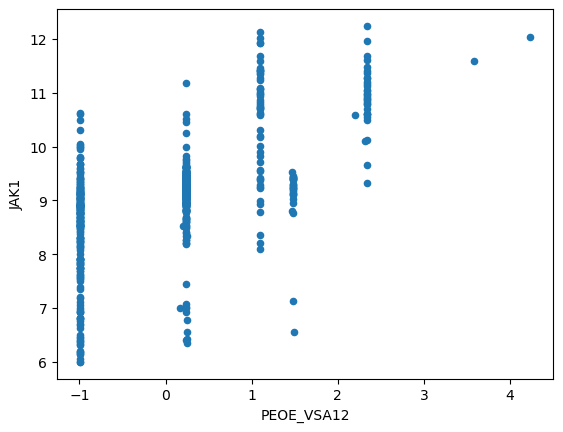

129 features removed
79 features remain
Number of non-normal high correlation features: 0


In [10]:
# Plotted out the relevant correlations to make sure nothing was amiss
ax1 = df_smiles.plot(kind="scatter", x='PEOE_VSA12', y='JAK1')
plt.show()
# Let's clean out any of the variables that don't have a correlation with any of the kinases

high_correlation_features = set()
for x in kinase_correlation_rankings:
    for y in kinase_correlation_rankings[x].to_dict():
        if kinase_correlation_rankings[x][y] > 0.5:
            high_correlation_features.add(y) 

print(str(len(feature_cols) - len(high_correlation_features)) + " features removed")
print(str(len(high_correlation_features)) + " features remain")
print("Number of non-normal high correlation features: " + str(len(high_correlation_features & set(non_normal_features))))

### Assumptions made
Here we are using the Pearson coefficient to determine correlation between each of the kinases values and the features. This means that we are assuming a linear relationship and that each feature follows a normal distribution. As we proved in the analysis this is not necessarily true for all of the features, as some do not follow normal distributions and others might have different relationships. We should later try to transform these features, but for now as none of them were deemed high correlation we will ignore them.

In [11]:
# Remove features that are colinear with other features
df = df_smiles[list(high_correlation_features)]
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def remove_high_correlations(df, high_corr_features):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr = au_corr.loc[au_corr > 0.95].rename_axis(["first", "second"]).reset_index()
    to_remove = au_corr["first"].tolist()
    
    return [feat for feat in high_corr_features if feat not in to_remove]

# display(pairs.colu)
new_high_corr_features = remove_high_correlations(df, high_correlation_features)
print("# features removed: " + str(len(high_correlation_features) - len(new_high_corr_features)))
print("Features remaining: " + str(len(new_high_corr_features)))
print(new_high_corr_features)

# features removed: 25
Features remaining: 54
['EState_VSA9', 'SlogP_VSA2', 'fr_NH0', 'fr_C_O_noCOO', 'PEOE_VSA8', 'BCUT2D_MRHI', 'PEOE_VSA2', 'TPSA', 'BCUT2D_LOGPLOW', 'HallKierAlpha', 'SMR_VSA1', 'EState_VSA10', 'FractionCSP3', 'EState_VSA2', 'PEOE_VSA3', 'EState_VSA5', 'PEOE_VSA4', 'MolLogP', 'SMR_VSA3', 'NumAromaticHeterocycles', 'fr_alkyl_halide', 'SMR_VSA7', 'PEOE_VSA14', 'VSA_EState7', 'RingCount', 'VSA_EState9', 'NumHeteroatoms', 'SMR_VSA9', 'VSA_EState2', 'qed', 'fr_halogen', 'VSA_EState6', 'VSA_EState1', 'NumSaturatedRings', 'Chi4v', 'fr_Ar_N', 'fr_benzene', 'NumRotatableBonds', 'fr_amide', 'NumHAcceptors', 'PEOE_VSA12', 'fr_Nhpyrrole', 'fr_piperdine', 'MaxPartialCharge', 'NumSaturatedHeterocycles', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BertzCT', 'MinEStateIndex', 'SlogP_VSA8', 'fr_sulfonamd', 'Chi2n', 'Kappa1', 'PEOE_VSA10']


## Next Steps
### Backward Feature Elimination
If I had more time, I would add backward feature elimination to the feature engineering process. Backward feature elimination is done by training some kind of easily explainable regressor on the processed data (I would use a gradient-boosted tree) and getting the feature importance from the regressor's evaluation. Then, I would remove the least important feature and repeat the process until the loss significantly increased.

I could also attempt forward feature selection, which is similar except you start with no features and add each one individually and choose the feature that gives the regressor the lowest loss. The iterate until all features are added or loss begins to increase.

### Transformation of Non-Linear/Non-Normal Features
I would like to try different transforms on the features to examine relationships between those that did not havev strong linear relationships with any of the kinase values. Examples of this would be logarithmic transformation, or applying Gaussian transformations to the non-normally distributed features. 